# Capstone project by Sebastien Peytrignet

# Trash or Treasure? Using machine learning to classify and segment images of litter

# Notebook 4: Classification problem C.2 - classifying materials

## 1) Load packages

In [17]:
%matplotlib inline
import os
import json
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 2) Load data for classification models

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Dataset path
dataset_path = '/content/drive/MyDrive/TACO'

In [20]:
# Dataset path
features_path = '/content/drive/MyDrive/TACO features'

In the previous steps, we selected 438 samples (or annotations) to use in our second classification problem. The class labels for those samples are included in the dataset 'c2_info', which we load again below.

In [21]:
# Load the image labels and information
with np.load("{}/{}".format(features_path,"classification-labels.npz"), allow_pickle=True) as npz_file:
    # It's a dictionary-like object
    print(list(npz_file.keys()))

    # Load the arrays
    c2_info = npz_file["c2"]
    c2_info_colnames = npz_file["c2_colnames"]

c2_info = pd.DataFrame(c2_info, columns=c2_info_colnames)
c2_info

['c1', 'c2', 's1', 'c1_colnames', 'c2_colnames', 's1_colnames']


id image_id c2_numlabel c2_label   bbox_pct  \
0       1        0         2.0    Glass  18.763902   
1       4        2         1.0  Plastic   5.937803   
2       6        3         1.0  Plastic   8.101703   
3       7        3         1.0  Plastic   2.534966   
4      13        5         1.0  Plastic  30.241929   
..    ...      ...         ...      ...        ...   
433  4763     1494         1.0  Plastic   1.172423   
434  4765     1494         2.0    Glass   0.858553   
435  4776     1497         2.0    Glass   2.502385   
436  4777     1497         2.0    Glass   1.871176   
437  4783     1499         2.0    Glass   1.635691   

                                  scene_category  
0                               Indoor, Man-made  
1                                       Pavement  
2                                     Vegetation  
3                                     Vegetation  
4                               Indoor, Man-made  
..                                           ...  
433  Vegetation & Pavement & Sand, Dirt, Pebbles  
434  Vegetation & Pavement & Sand, Dirt, Pebbles  
435  Vegetation & Sand, Dirt, Pebbles & Pavement  
436  Vegetation & Sand, Dirt, Pebbles & Pavement  
437                             Other background  

[438 rows x 6 columns]

We also load the images themselves, which are stored in a 4-dimensional numpy array 'c2_images'.

In [22]:
# Load the processed (cropped+framed) images
with np.load("{}/{}/{}".format(features_path,"widen_param_0.05","classification-images.npz"), allow_pickle=True) as npz_file:
    # It's a dictionary-like object
    print(list(npz_file.keys()))

    # Load the arrays
    c2_images = npz_file["c2"]

['c1', 'c2', 's1', 's1_masks']


We can see from the pie chart below that our original sample was unbalanced: there are three plastic bottles for each glass bottle.

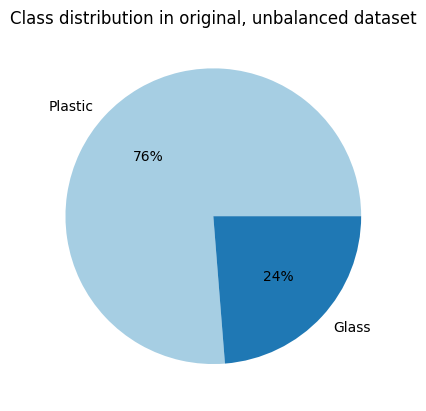

In [23]:
piecolors = sns.color_palette('Paired',2)
plt.pie(c2_info.c2_label.value_counts(normalize=False), labels = c2_info.c2_label.value_counts(normalize=False).index, colors = piecolors, autopct='%.0f%%')
plt.title("Class distribution in original, unbalanced dataset")
plt.show()

## 3) Extract features

We use a pre-trained model, ResNet50V2, to create features that we will use in our machine learning models. ResNet50V2 is a deep convolutional neural network architecture used for image classification. This model was trained on the ImageNet dataset, which contains over 1 million images from [1,000 different image categories](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/). It has a top-1 accuracy of 76.0% on those objects.

This dataset includes a wide variety of images, such as animals, objects and people. Looking at the 1,000 categories included in ImageNet we can see that ResNet50V2 has already been trained to detect beer bottles (made of glass) and water bottles (made of plastic).

In [24]:
import tensorflow as tf
import tensorflow_hub as hub

In [25]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

First, we check that our images have the required shape of 224x224 pixels, and we rescale the values for each pixel to the 0-1 range.

In [26]:
c2_images.shape

(438, 224, 224, 3)

In [27]:
c2_data_processed = c2_images*1./255.

In [28]:
feature_extractor_layer = hub.KerasLayer(resnet_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=(224, 224, 3)) # define the input image shape

Then, we generate our 2,048 features in batches of 32 images to avoid overwhelming our runtime's memory.

In [29]:
#Generate high-level features in batches

batch_size = 32

for i in range(0, c2_data_processed.shape[0], batch_size):

  batch_c2_features = pd.DataFrame(feature_extractor_layer(c2_data_processed[i:(i+batch_size),:,:,:]).numpy())

  if i==0:
    c2_features = batch_c2_features
  else:
    c2_features = pd.concat([c2_features,batch_c2_features])

Then, we add our class labels (in string and numeric format) into the features dataset.

In [30]:
#Create training dataframe with features from ResNet50V2
c2_features.reset_index(drop=True,inplace=True)
c2_features.columns = c2_features.columns+1
c2_features = c2_features.add_prefix('feat_')

#Add variables
c2_features["annotation_id"] = c2_info["id"].copy()
c2_features["c2_label"] = c2_info["c2_label"].copy()
c2_features["c2_numlabel"] = c2_info["c2_numlabel"].copy()
c2_features = c2_features[c2_features.columns[::-1]]

#Inspect first few rows
c2_features.head(10)

c2_numlabel c2_label annotation_id  feat_2048  feat_2047  feat_2046  \
0         2.0    Glass             1   0.000000   0.050309   0.489718   
1         1.0  Plastic             4   0.052836   0.000000   0.000000   
2         1.0  Plastic             6   0.004976   0.008608   0.077122   
3         1.0  Plastic             7   2.988688   0.241005   0.000000   
4         1.0  Plastic            13   0.169035   0.300295   0.300800   
5         1.0  Plastic            18   0.619307   0.737272   0.533513   
6         1.0  Plastic            20   0.000000   0.034537   0.227170   
7         2.0    Glass            24   0.000000   0.000000   1.210301   
8         1.0  Plastic            32   0.004491   0.000000   0.482238   
9         1.0  Plastic            33   0.000000   0.000000   0.093688   

   feat_2045  feat_2044  feat_2043  feat_2042  ...   feat_10    feat_9  \
0   0.000000   0.032107   0.124284   0.000000  ...  2.571053  5.334684   
1   0.000000   0.279649   0.000000   0.000000  ...  0.004447  0.320454   
2   0.000000   0.341326   0.890148   0.000000  ...  0.727989  0.731481   
3   0.286296   0.158817   0.265926   0.000000  ...  0.000000  0.000000   
4   0.000000   0.000000   0.000000   0.000000  ...  0.216906  1.165066   
5   0.000000   0.269418   0.000000   0.000607  ...  0.000000  0.279993   
6   0.361045   0.094274   0.000000   0.000000  ...  0.057820  0.150799   
7   0.000000   0.197193   0.065022   0.000000  ...  0.000000  0.280559   
8   0.000000   0.000000   0.050584   0.000000  ...  0.000000  0.405168   
9   0.046956   0.000000   0.164229   0.009532  ...  0.044652  0.669637   

     feat_8    feat_7    feat_6    feat_5    feat_4    feat_3    feat_2  \
0  0.000000  0.792219  0.000000  0.080971  0.052082  0.000000  0.000000   
1  0.000000  0.372666  0.000000  0.126056  0.023611  0.000000  0.064649   
2  0.387772  0.143635  0.000000  0.017650  0.011170  0.051558  1.469806   
3  0.055437  0.357557  0.000000  0.078872  0.227038  0.127127  0.314141   
4  0.000000  0.164490  0.000000  0.498832  0.222087  0.000000  0.000000   
5  0.000000  0.508030  0.005348  0.623931  0.049480  0.000000  0.264279   
6  0.022054  4.651942  0.000000  0.011131  0.000000  0.022945  0.000000   
7  0.078484  0.007350  0.000000  0.000000  0.121353  0.208527  0.129406   
8  0.000000  0.088793  0.000000  0.117654  0.000000  0.260111  0.001729   
9  0.118549  1.124504  0.000000  0.000000  0.209831  0.002281  0.024342   

     feat_1  
0  0.105036  
1  0.554043  
2  0.000000  
3  0.037347  
4  2.758749  
5  0.094424  
6  0.011357  
7  0.000000  
8  0.216298  
9  0.056511  

[10 rows x 2051 columns]

## 4) Visualize the data

Now, let's visualize the samples included in our classification problem to check that they are labelled properly and have been resized in the way we expected.

We notice that glass and plastic bottles tend to have different shapes, as well as different materials. Therefore, our classification models will be picking up on more than differences in materials.

In [31]:
from random import sample

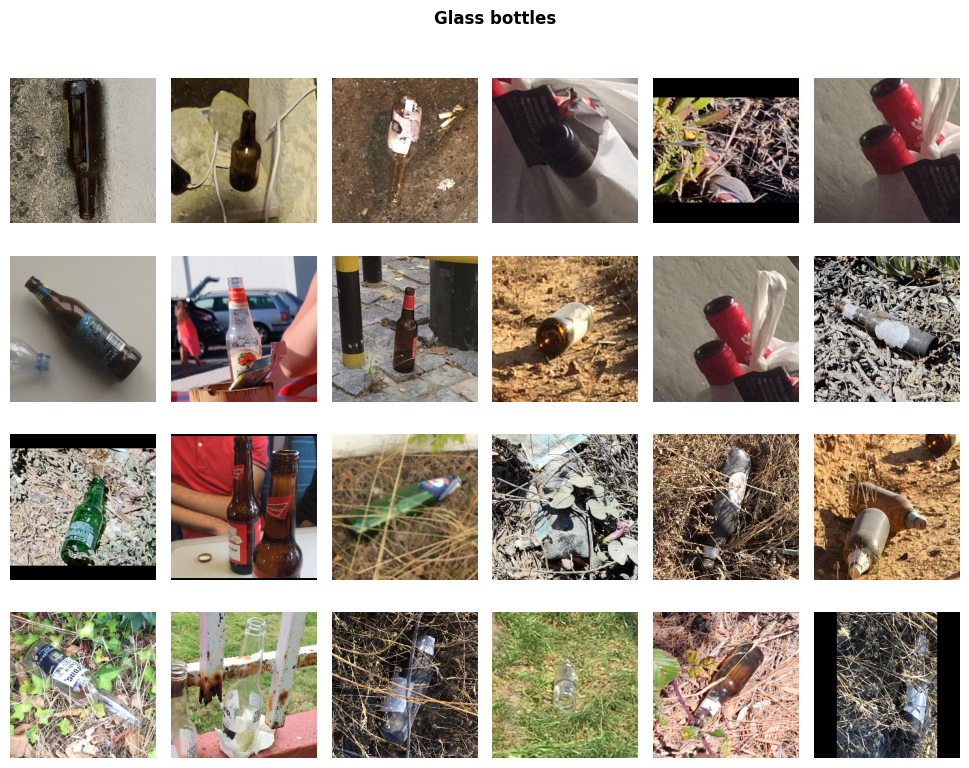

In [32]:
annotations_samples = sample(list(c2_features.index[c2_features.c2_label=="Glass"]),24)

fig, axes = plt.subplots(4,6,figsize = (10,8))

for (annotindex, ax) in zip(annotations_samples,axes.flatten()):

  ax.imshow(c2_images[annotindex,:,:,:])
  ax.set_axis_off()

fig.suptitle("Glass bottles", fontsize=12, fontweight ="bold")
plt.tight_layout(rect=[0, 0, 0.98, 0.98])
plt.show()

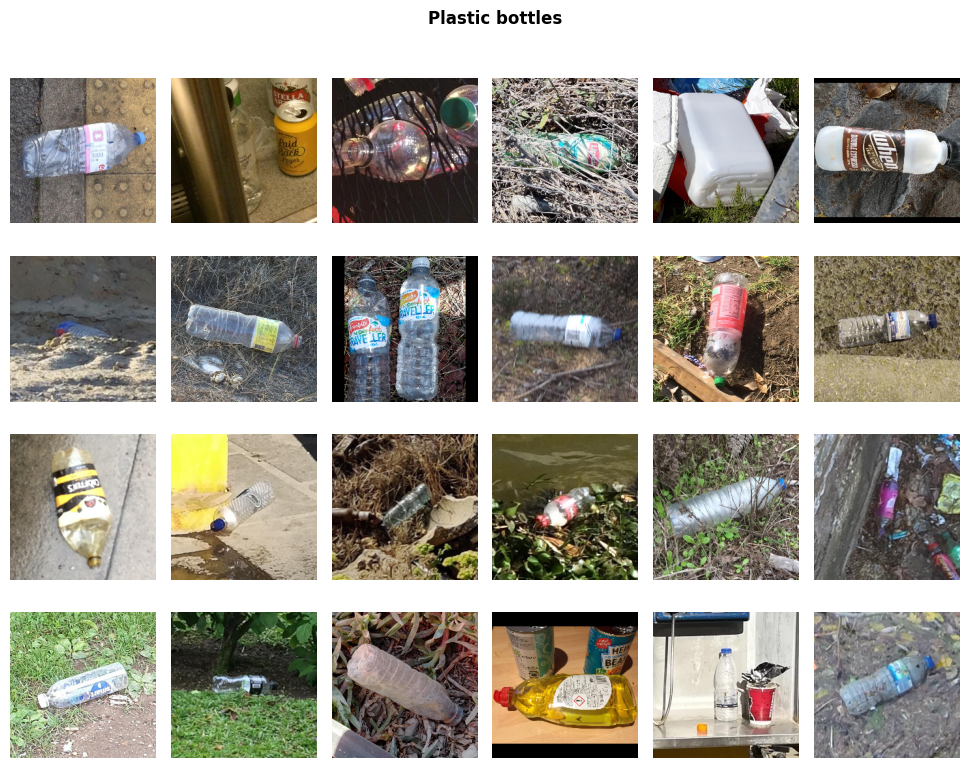

In [33]:
annotations_samples = sample(list(c2_features.index[c2_features.c2_label=="Plastic"]),24)

fig, axes = plt.subplots(4,6,figsize = (10,8))

for (annotindex, ax) in zip(annotations_samples,axes.flatten()):

  ax.imshow(c2_images[annotindex,:,:,:])
  ax.set_axis_off()

fig.suptitle("Plastic bottles", fontsize=12, fontweight ="bold")
plt.tight_layout(rect=[0, 0, 0.98, 0.98])
plt.show()

## 5) Create a balanced dataset

As shown in first pie chart above, our original dataset is unbalanced. This could result in the following issues in our classification problem:

* Overfitting to the most frequent class: When the most frequent class class has a significantly larger proportion of data points, the model may become overly focused on recognizing patterns within this class.

* Misleading accuracy: Overall accuracy may appear high even when the model performs poorly on the minority class.

We choose to balance our dataset using random undersampling. Undersampling reduces the number of majority class instances to bring the classes closer to balance. We choose this approach because of its simplicity - it also avoids creating artificial duplicates of our minority class images. A drawback is that we removed usable samples.

In [34]:
from imblearn.under_sampling import RandomUnderSampler

In [35]:
X = c2_features.drop(["c2_label","c2_numlabel","annotation_id"], axis=1)
ylab = c2_features["c2_label"]

random_under_sampler = RandomUnderSampler(random_state=0)

X_balanced, ylab_balanced = random_under_sampler.fit_resample(X, ylab)

In [36]:
X.shape, ylab.shape

((438, 2048), (438,))

In [37]:
X_balanced.shape, ylab_balanced.shape

((208, 2048), (208,))

## 6) Split out the testing set

After having balanced our dataset, we split it into a training/validation set (80%) and a testing set (20%). We choose to combine the training and validation set into one, because we will be applying 5-fold cross validation later on.

In [38]:
from sklearn.model_selection import train_test_split

X_trainval, X_test, ylab_trainval, ylab_test = train_test_split(X_balanced, ylab_balanced,
                                                    test_size=0.2,
                                                    random_state=8,
                                                    stratify=ylab_balanced)

del X
del X_balanced
del ylab
del ylab_balanced

#Pandas dataframe for EDA

c2_trainval = pd.concat([ylab_trainval, X_trainval], axis=1)

#Numpy arrays for ML models

  #X features
X_trainval = X_trainval.values
X_test = X_test.values

  #Y labels
ylab_trainval = ylab_trainval.values
ylab_test = ylab_test.values

print("X_trainval: {}, ylab_trainval: {}".format(X_trainval.shape,ylab_trainval.shape))
print("X_test: {}, ylab_test: {}".format(X_test.shape,ylab_test.shape))

X_trainval: (166, 2048), ylab_trainval: (166,)
X_test: (42, 2048), ylab_test: (42,)


We visualize the class distribution of the training/validation and testing sets and we are satisfied that these two samples are now balanced.

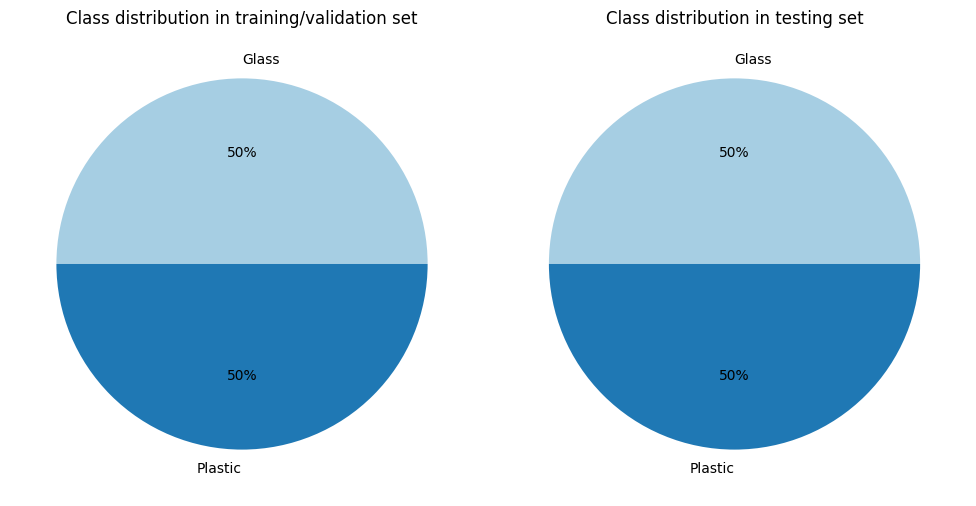

In [39]:
plt.rcParams["figure.figsize"] = [10,5]
plt.rcParams["figure.autolayout"] = True

plt.subplot(1, 2, 1)
plt.pie(pd.Series(ylab_trainval).value_counts(normalize=False), labels = pd.Series(ylab_trainval).value_counts(normalize=False).index, colors = piecolors, autopct='%.0f%%')
plt.title("Class distribution in training/validation set")

plt.subplot(1, 2, 2)
plt.pie(pd.Series(ylab_test).value_counts(normalize=False), labels = pd.Series(ylab_test).value_counts(normalize=False).index, colors = piecolors, autopct='%.0f%%')
plt.title("Class distribution in testing set")

plt.show()

plt.rcParams.update(plt.rcParamsDefault)

## 7) Feature analysis and correlations

Next, we will run some exploratory data analysis on the 2,048 features created by the ResNet50V2 model.

In [ ]:
c2_trainval.head(10)

c2_label  feat_2048  feat_2047  feat_2046  feat_2045  feat_2044  \
17     Glass   0.294048   0.051386   0.000000   0.000000   0.000000   
155  Plastic   0.000000   0.000000   0.022896   0.059656   0.036307   
73     Glass   0.000000   0.200875   0.000000   0.298170   0.000000   
163  Plastic   0.023863   0.000000   0.068729   0.341720   0.000000   
75     Glass   0.036569   0.000000   0.128281   0.061904   0.509412   
70     Glass   0.061917   0.038713   0.000000   0.000000   1.037915   
82     Glass   0.116081   0.016332   0.084138   0.010757   0.345631   
3      Glass   0.000000   0.688502   1.532184   0.255386   1.433332   
134  Plastic   0.000000   0.113936   0.400239   0.035594   0.078700   
107  Plastic   0.077615   1.365878   0.000000   0.065904   0.468886   

     feat_2043  feat_2042  feat_2041  feat_2040  ...   feat_10    feat_9  \
17    1.171346   0.000000   1.485420   0.055461  ...  0.000000  0.321547   
155   0.000000   0.001572   0.046568   0.026014  ...  0.000000  0.020856   
73    0.720766   0.001643   1.594207   5.301524  ...  0.604357  1.399159   
163   0.192791   0.000000   1.268052   1.591543  ...  2.556148  0.000000   
75    0.000000   0.000000   0.045742   7.248216  ...  0.000000  0.316373   
70    0.199727   0.000000   5.553576   3.906883  ...  2.204390  0.129674   
82    0.049561   0.000000   7.920314   2.395989  ...  0.000000  0.070936   
3     0.089231   0.003958   0.813546   0.657747  ...  0.470326  0.042035   
134   0.000459   0.000000   2.101594   2.889711  ...  0.000000  0.896024   
107   0.000000   0.000000   1.271753   0.325025  ...  0.000310  0.027737   

       feat_8    feat_7  feat_6    feat_5    feat_4    feat_3    feat_2  \
17   0.000000  1.266475     0.0  0.010291  0.000000  0.058699  0.000000   
155  0.000000  6.043571     0.0  0.306491  0.000000  0.050863  0.000000   
73   0.094990  1.262855     0.0  0.000000  0.000000  0.080934  0.013744   
163  0.356464  1.588225     0.0  0.000000  0.720533  0.481464  0.807360   
75   0.000000  0.320973     0.0  0.415470  0.000000  0.000000  0.026141   
70   0.081881  0.513346     0.0  0.379819  0.000000  0.000000  0.286872   
82   0.000000  0.040188     0.0  0.641368  0.764720  0.000000  0.291000   
3    0.032950  0.763606     0.0  0.195090  0.000000  1.251374  0.000000   
134  0.000000  2.837010     0.0  0.000000  0.000000  0.000000  0.000000   
107  0.000000  1.753811     0.0  0.055073  0.000000  0.191940  0.292454   

       feat_1  
17   0.411685  
155  0.000533  
73   0.444669  
163  0.090874  
75   0.143698  
70   0.670556  
82   0.686540  
3    0.006406  
134  0.000000  
107  0.790953  

[10 rows x 2049 columns]

We can see that there are no missing values in these features.

In [ ]:
feature_column_names = c2_trainval.columns[c2_trainval.columns.str.startswith('feat')]
c2_trainval[feature_column_names] = c2_trainval[feature_column_names].apply(pd.to_numeric)

In [ ]:
(c2_trainval.drop(["c2_label"], axis=1).isna().sum(axis=0)>0).sum() #No missing values in any of the features

0

Then, we see that the minimum value for all features is zero, or close to zero.

In [ ]:
c2_trainval.describe()

feat_2048   feat_2047   feat_2046   feat_2045   feat_2044   feat_2043  \
count  166.000000  166.000000  166.000000  166.000000  166.000000  166.000000   
mean     0.521100    0.179876    0.396810    0.135424    0.323313    0.364440   
std      0.933756    0.304227    0.701816    0.432479    0.516442    0.552158   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.014914    0.000000    0.000751    0.000000   
50%      0.115604    0.043423    0.144636    0.000000    0.103380    0.115898   
75%      0.680644    0.177799    0.509247    0.096332    0.369098    0.476710   
max      7.265749    1.531068    5.496685    4.189212    2.572293    2.919290   

        feat_2042   feat_2041   feat_2040   feat_2039  ...     feat_10  \
count  166.000000  166.000000  166.000000  166.000000  ...  166.000000   
mean     0.001504    2.457361    1.700245    0.566408  ...    0.413649   
std      0.003264    2.029888    1.919120    1.157293  ...    0.851527   
min      0.000000    0.001807    0.000000    0.000000  ...    0.000000   
25%      0.000000    0.895939    0.167685    0.006850  ...    0.000000   
50%      0.000000    1.902994    0.986372    0.148498  ...    0.037338   
75%      0.001593    3.673458    2.712698    0.576151  ...    0.369983   
max      0.023439   11.155269    9.595311    6.662166  ...    5.792644   

           feat_9      feat_8      feat_7      feat_6      feat_5      feat_4  \
count  166.000000  166.000000  166.000000  166.000000  166.000000  166.000000   
mean     0.493824    0.221817    1.411466    0.000240    0.246345    0.090126   
std      0.713168    0.407889    1.777380    0.001154    0.364397    0.256693   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.058067    0.000000    0.233600    0.000000    0.006496    0.000000   
50%      0.259841    0.043683    0.905942    0.000000    0.105300    0.003322   
75%      0.610813    0.266236    1.733676    0.000000    0.358152    0.070480   
max      5.334680    2.329399   10.839160    0.007527    2.238178    2.408182   

           feat_3      feat_2      feat_1  
count  166.000000  166.000000  166.000000  
mean     0.108168    0.197401    0.629508  
std      0.239271    0.401269    0.770246  
min      0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.041885  
50%      0.020713    0.031112    0.368097  
75%      0.104868    0.233828    0.925349  
max      2.235762    3.228076    3.996098  

[8 rows x 2048 columns]

In [ ]:
c2_trainval.describe().loc["min",:].unique() #There are no negative values

array([0.        , 0.00180684])

The maximum value for the 2,048 features goes up to 25 for some features. Therefore, there is some variation in the range of our features.

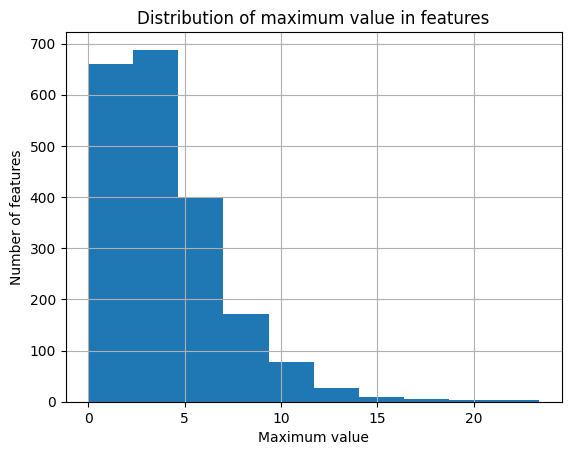

In [ ]:
c2_trainval.describe().loc["max",:].hist()
plt.title("Distribution of maximum value in features")
plt.xlabel("Maximum value")
plt.ylabel("Number of features")
plt.show()

The 2,048 features often have a value of zero. In fact, from below, we can see that about 22% of features are majority-zero.

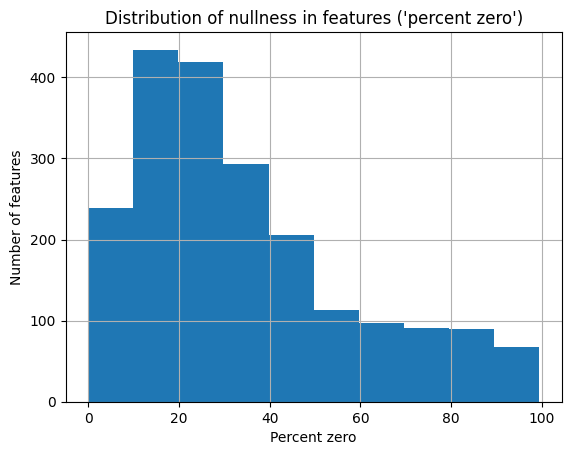

In [ ]:
percent_zero_in_features = (c2_trainval.drop(["c2_label"], axis=1).apply(lambda x: x==0, axis=0).sum(axis=0))/c2_trainval.shape[0]*100
percent_zero_in_features.hist()
plt.title("Distribution of nullness in features ('percent zero')")
plt.xlabel("Percent zero")
plt.ylabel("Number of features")
plt.show()

In [ ]:
(percent_zero_in_features>50).sum()/c2_trainval.shape[1]

0.21815519765739386

The heatmaps below diplay the values of those features for each class. We can see that some features (vertical lines) are more active in some classes compared to others, with consistently higher values across all samples.

In [ ]:
minrange = np.min(c2_trainval.describe().loc["min",:])
maxrange = np.max(c2_trainval.describe().loc["max",:])

In [ ]:
c2_trainval["c2_label"].unique()

array(['Glass', 'Plastic'], dtype=object)

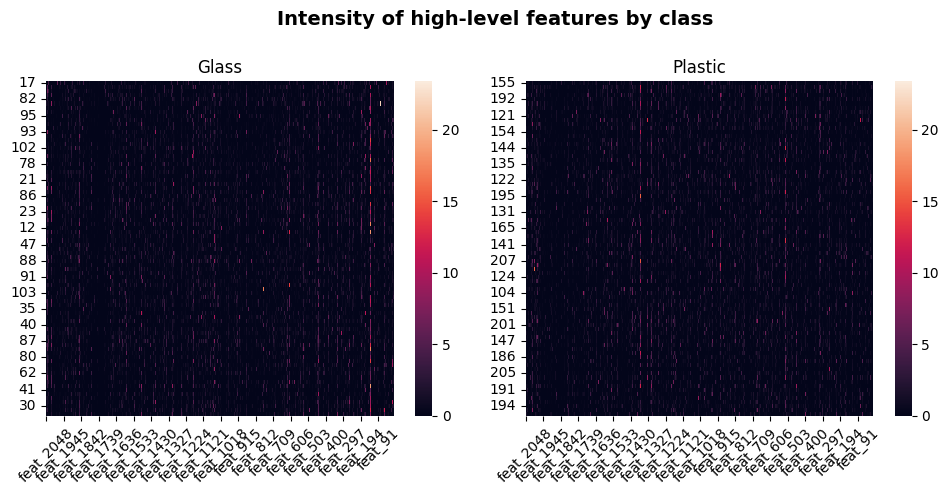

In [ ]:
fig, axes = plt.subplots(1,2,figsize = (10,5))

for (var, ax) in zip(['Glass', 'Plastic'],axes.flatten()):
    sns.heatmap(ax=ax, data=c2_trainval.loc[c2_trainval.c2_label==var,c2_trainval.columns.str.startswith("feat")], vmin=minrange, vmax=maxrange)
    ax.set_title(var)
    ax.tick_params(axis='x', labelrotation=45, labelsize=10)

fig.suptitle("Intensity of high-level features by class", fontsize=14, fontweight ="bold")
plt.tight_layout(rect=[0, 0, 0.98, 0.98])
plt.show()

Next, we will run some statistical tests to assess whether the distribution of each feature varies by class. Using the Kruskal-Wallis test, We will be testing the null hypothesis that the median of each feature is the same across the five classes. We apply a Bonferroni correction to each p-value, to account for the fact that we are testing 2,048 hypotheses at the same time. Indeed, when multiple comparisons are made, the probability of false positives increases.

In [ ]:
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

In [ ]:
kw_tests=[]

for varname in list(c2_trainval.columns[c2_trainval.columns.str.startswith("feat")]): #Iterate over all the feature names
    groups = [c2_trainval[c2_trainval["c2_label"] == group][varname] for group in c2_trainval["c2_label"].unique()]
    stat, pval = stats.kruskal(*groups,nan_policy="omit")
    kw_tests.append(
            {
                "feature": varname,
                "test_stat": stat,
                "pval": pval
            }
        )

kw_tests = pd.DataFrame(kw_tests)

kw_tests["pval_adj"] = multipletests(kw_tests.pval, alpha=0.05, method='bonferroni', maxiter=1, is_sorted=False, returnsorted=False)[1]
kw_tests["Ho_rejected"] = multipletests(kw_tests.pval, alpha=0.05, method='bonferroni', maxiter=1, is_sorted=False, returnsorted=False)[0]
kw_tests.sort_values(by="pval_adj")

feature  test_stat          pval  pval_adj  Ho_rejected
220   feat_1828  38.000800  7.071563e-10  0.000001         True
236   feat_1812  36.774581  1.326080e-09  0.000003         True
973   feat_1075  31.607827  1.886676e-08  0.000039         True
173   feat_1875  29.400769  5.885428e-08  0.000121         True
956   feat_1092  28.469830  9.516997e-08  0.000195         True
...         ...        ...           ...       ...          ...
689   feat_1359   0.756979  3.842756e-01  1.000000        False
688   feat_1360   1.148461  2.838716e-01  1.000000        False
687   feat_1361   3.359225  6.682950e-02  1.000000        False
700   feat_1348   0.125326  7.233279e-01  1.000000        False
2047     feat_1   0.186329  6.659894e-01  1.000000        False

[2048 rows x 5 columns]

Based on the p-values shown above, features 1828 and 1075 appear to be able to distinguish particularly well between the two classes. We will use these two features later in a simple logistic model.

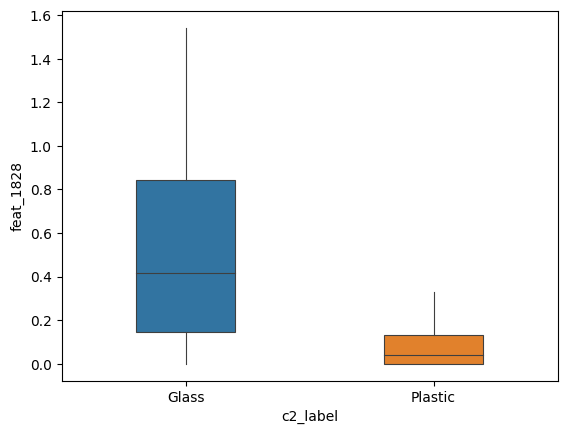

In [ ]:
sns.boxplot(data=c2_trainval, x="c2_label", y="feat_1828", notch=False, showcaps=False, showfliers = False, width=0.4, linewidth=0.8)
plt.show()

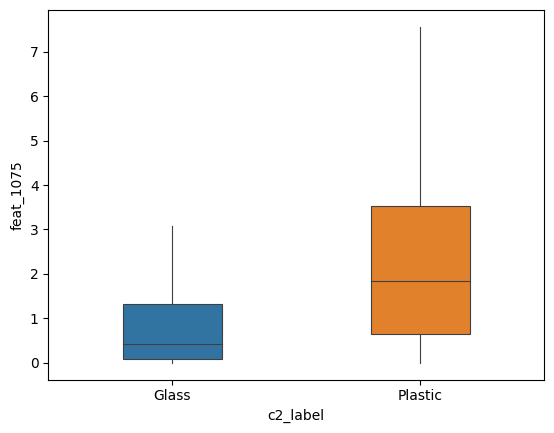

In [ ]:
sns.boxplot(data=c2_trainval, x="c2_label", y="feat_1075", notch=False, showcaps=False, showfliers = False, width=0.4, linewidth=0.8)
plt.show()

## 8) PCA analysis

Next, we will run a principal component analysis on the 2,048 features. Running our analysis using a limited number of principal components, rather than the whole set of features, might be a useful way to reduce dimensionality in our machine learning models while retaining variables that capture variation across the entire feature space.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [ ]:
feature_engineering = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA())    ]
)

The first 50 principal components explain 64% of the total variance and the first one just over 4% - which suggests that our original features may not be highly correlated with each other.

In [ ]:
X_trainval_pcs = feature_engineering.fit_transform(X_trainval)

In [ ]:
pve = feature_engineering.named_steps["pca"].explained_variance_ratio_

In [ ]:
np.cumsum(pve)[0]

0.04546919

In [ ]:
np.cumsum(pve)[49]

0.63520724

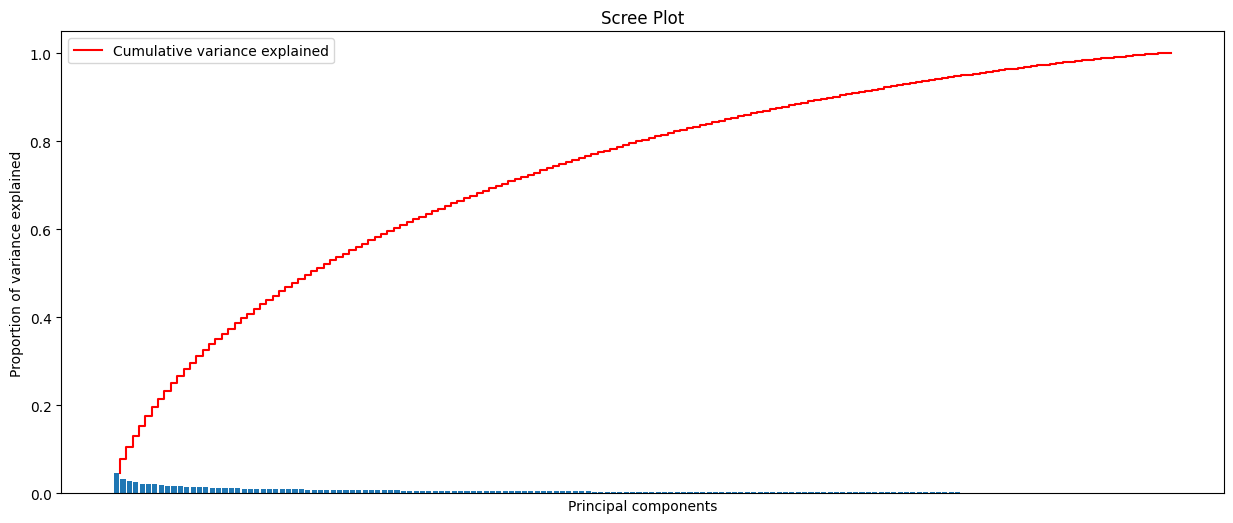

In [ ]:
plt.figure(figsize=(15,6))

# Create bar plot
xcor = np.arange(1, len(pve) + 1)  # 1,2,..,n_components
plt.bar(xcor, pve)
plt.xticks(xcor)

# Add cumulative sum
plt.step(xcor + 0.5,np.cumsum(pve),label="Cumulative variance explained",color='red')

# Add labels
plt.xlabel("Principal components")
plt.xticks([])
plt.ylabel("Proportion of variance explained")
plt.title('Scree Plot')
plt.legend()
plt.show()

## 9) Baseline model performance

Our baseline performance metric will be the percentage of samples correctly predicted if we predict the most frequent class for all samples. Given we have a perfectly balanced dataset with two classes, our baseline accuracy is therefore 50%.

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
# create dummy classifier
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=1)

In [ ]:
# train a model
dummy_clf.fit(X_trainval, ylab_trainval)

DummyClassifier(random_state=1, strategy='most_frequent')

In [ ]:
# get accuracy score
dummy_clf.score(X_trainval, ylab_trainval)

0.5

In [ ]:
# get accuracy score
dummy_clf.score(X_test, ylab_test)

0.5

## 10) k-NN model

Our first machine learning model will be K nearest neighbours (k-NN). We choose a k-NN model because it is relatively simple to implement, but it can also classify data that is not linearly separable in the feature space.

With a high number of features (e.g. over 2,000) the distance metric used in k-NN can become irrelevant. Indeed, because of the curse of dimensionality, all samples will tend to have a similar distance to each other in a space with a high number of dimensions.

For this reasons, we first reduce the number of dimensions using principal components.

### Model set-up

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
knn_estimator = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("knn", KNeighborsClassifier())
    ]
)

In [ ]:
knn_estimator.named_steps

{'scaler': StandardScaler(), 'pca': PCA(), 'knn': KNeighborsClassifier()}

In [ ]:
knn_estimator.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('pca', PCA()),
  ('knn', KNeighborsClassifier())],
 'verbose': False,
 'scaler': StandardScaler(),
 'pca': PCA(),
 'knn': KNeighborsClassifier(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': None,
 'pca__n_oversamples': 10,
 'pca__power_iteration_normalizer': 'auto',
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

### Grid search with cross-validation to find optimal hyper-parameters

We need to find the optimal value for our two hyper-parameters: the number of principal components, and the number of neighbours (k). We will select the combination of hyper-parameters that maximizes the mean accuracy on the validation sets.

This type of grid search with cross validation can be very computationally intensive. For this reason, we could search over a selection of random combinations of hyperparameters using the RandomizedSearchCV method or perform an exhaustive GridSearch. We choose to perform an exhaustive GridSearch, although this can take up to one hour.

Finally, we reduce the number of folds in cross-validation from 5 to 3.

In [ ]:
grid = {
    "pca__n_components": list(range(1,100+1)),
    "knn__n_neighbors": list(range(1,30+1)),
    }

In [ ]:
knn_random_search = GridSearchCV(
    knn_estimator,
    cv=3,
    param_grid=grid,
    return_train_score=True,
    refit=True,
    verbose=True,
    n_jobs=-1
)

In [ ]:
knn_random_search.fit(X_trainval, ylab_trainval)

Fitting 3 folds for each of 3000 candidates, totalling 9000 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30],
                         'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                               11, 12, 13, 14, 15, 16, 17, 18,
                                               19, 20, 21, 22, 23, 24, 25, 26,
                                               27, 28, 29, 30, ...]},
             return_train_score=True, verbose=True)

The highest accuracy is achieved with the first 23 principal components and 12 neighbours.

In [ ]:
knn_random_search.best_params_

{'knn__n_neighbors': 12, 'pca__n_components': 23}

In [ ]:
knn_random_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_knn__n_neighbors', 'param_pca__n_components', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

In [ ]:
knn_param_search_results = pd.DataFrame(
    {
        "k": knn_random_search.cv_results_["param_knn__n_neighbors"],
        "n_components": knn_random_search.cv_results_["param_pca__n_components"],
        "mean_tr": knn_random_search.cv_results_["mean_train_score"],
        "mean_val": knn_random_search.cv_results_["mean_test_score"]
        }
)

knn_param_search_results.sort_values(by="mean_val", ascending=False)[:10]

k n_components   mean_tr  mean_val
1122  12           23  0.822331  0.783550
928   10           29  0.822359  0.783225
522    6           23  0.834371  0.777597
1926  20           27  0.807316  0.777597
925   10           26  0.834398  0.777381
1132  12           33  0.831368  0.777273
1136  12           37  0.828392  0.777165
924   10           25  0.843407  0.771645
1924  20           25  0.804341  0.771645
927   10           28  0.831422  0.771537

In the heatmap below, we can see that increasing the number of principal components (PCs) increases the accuracy up until approximately 20 to 30 PCs but, after this, the mean validation accuracy decreases.

Similarly, the optimal number of neighbours seems to be around 12.

In [ ]:
heatmap_data = knn_param_search_results.groupby(["k","n_components"]).agg(
                          mean_val = pd.NamedAgg(column ='mean_val', aggfunc='mean')).unstack(level=1)

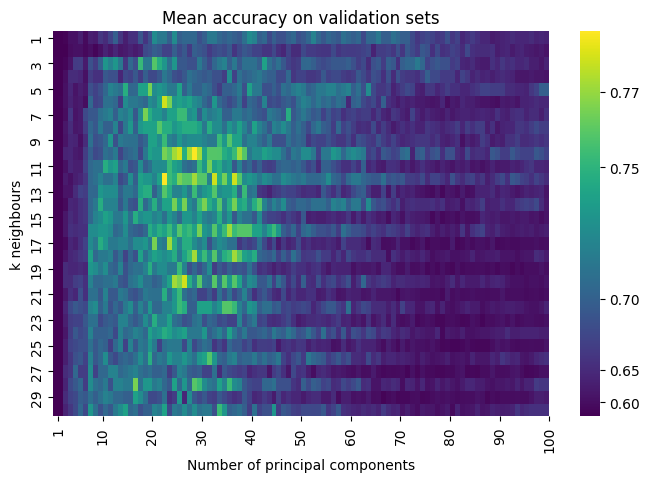

In [ ]:
from matplotlib.colors import LogNorm, PowerNorm
plt.figure(figsize=(8,5))
ax = sns.heatmap(data=heatmap_data, cmap='viridis', cbar=True,
            norm=PowerNorm(4), cbar_kws={'ticks': [0.60,0.65,0.70,0.75,0.77,0.79]})
ax.set_xticks([1,10,20,30,40,50,60,70,80,90,100], labels=[1,10,20,30,40,50,60,70,80,90,100])
ax.set_xlabel("Number of principal components")
ax.set_ylabel("k neighbours")
ax.set_title("Mean accuracy on validation sets")
plt.show()

This is confirmed by the training and validation curves below. For each value of K, we show the range of accuracy that can be achieved by varying the number of principal components used in the model.

With one neighbour, the training accuracy is 100% because the nearest neighbour of each sample is the sample itself. A relatively high validation accuracy is achieved with a small number of neighbours. The accuracy on the training set is consistently higher than the validation accuracy, which suggests the model is overfitting on average for all values of k.

In [ ]:
#Summarise accuracy according to hyperparameter k
knn_curves_by_k = knn_param_search_results.groupby(["k"]).agg(
                          mean_val = pd.NamedAgg(column ='mean_val', aggfunc='mean'),
                          mean_val_min = pd.NamedAgg(column ='mean_val', aggfunc='min'),
                          mean_val_max = pd.NamedAgg(column ='mean_val', aggfunc='max'),
                          mean_tr = pd.NamedAgg(column ='mean_tr', aggfunc='mean'),
                          mean_tr_min = pd.NamedAgg(column ='mean_tr', aggfunc='min'),
                          mean_tr_max = pd.NamedAgg(column ='mean_tr', aggfunc='max'))

#Upper and lower bounds of validation accuracy
ub_val = (knn_curves_by_k.mean_val_max-knn_curves_by_k.mean_val).values.transpose()
lb_val = (-1*(knn_curves_by_k.mean_val_min-knn_curves_by_k.mean_val)).values.transpose()
val_bounds = np.stack([lb_val,ub_val],axis=0)

#Upper and lower bounds of training accuracy
ub_train = (knn_curves_by_k.mean_tr_max-knn_curves_by_k.mean_tr).values.transpose()
lb_train = (-1*(knn_curves_by_k.mean_tr_min-knn_curves_by_k.mean_tr)).values.transpose()
train_bounds = np.stack([lb_train,ub_train],axis=0)

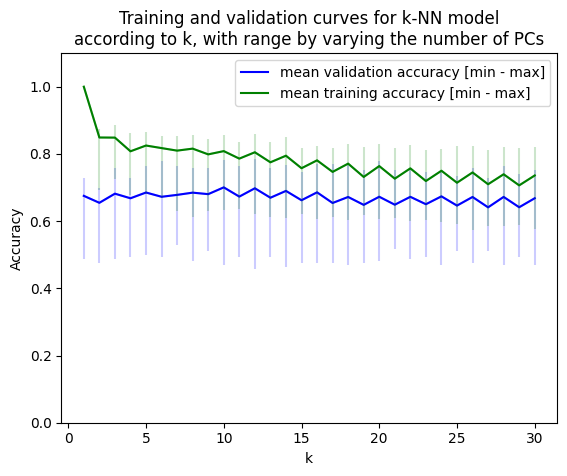

In [ ]:
# Validation sets
plt.plot(knn_curves_by_k.index,knn_curves_by_k.mean_val, label="mean validation accuracy [min - max]", color="blue")
plt.errorbar(knn_curves_by_k.index,knn_curves_by_k.mean_val, yerr=val_bounds, color="blue", alpha=0.2)
#Training sets
plt.plot(knn_curves_by_k.index,knn_curves_by_k.mean_tr, label="mean training accuracy [min - max]", color="green")
plt.errorbar(knn_curves_by_k.index,knn_curves_by_k.mean_tr, yerr=train_bounds, color="green", alpha=0.2)
#Chart labels
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.ylim(0,1.1)
plt.title("Training and validation curves for k-NN model\naccording to k, with range by varying the number of PCs")
plt.legend()
plt.show()

### Assess performance on the test set

Finally, we assess the performance of our tuned k-NN model on the testing set, which was set apart at the beginning.

In [ ]:
test_set_predictions = knn_random_search.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
def get_report(truelabels,predlabels):
    print(classification_report(y_true=truelabels, y_pred=predlabels))

In [ ]:
def get_confusion_matrix(truelabels,predlabels):
    cm_test_labels = pd.Series(truelabels).value_counts().index
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true=truelabels, y_pred=predlabels, labels=cm_test_labels), display_labels=cm_test_labels)
    disp.plot()
    plt.show()

The overall accuracy of the model is 81%, and recall and precision are high for both classes (over 75%).

In [ ]:
get_report(ylab_test, test_set_predictions)

              precision    recall  f1-score   support

       Glass       0.78      0.86      0.82        21
     Plastic       0.84      0.76      0.80        21

    accuracy                           0.81        42
   macro avg       0.81      0.81      0.81        42
weighted avg       0.81      0.81      0.81        42



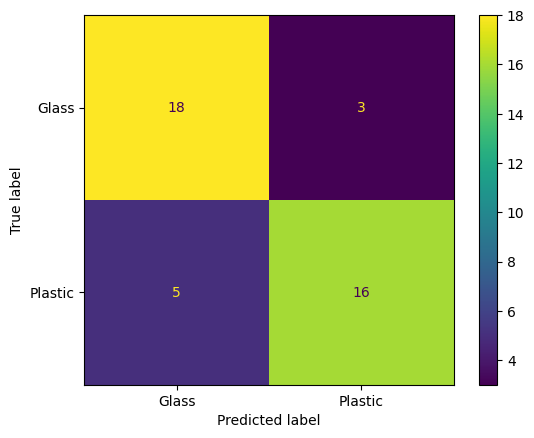

In [ ]:
get_confusion_matrix(ylab_test, test_set_predictions)

Finally, we produce a receiver operating characteristic (ROC) curve for this model. With an AUC (area under ROC curve) of 0.88, we can see that this simple k-NN model achieves a good performance.

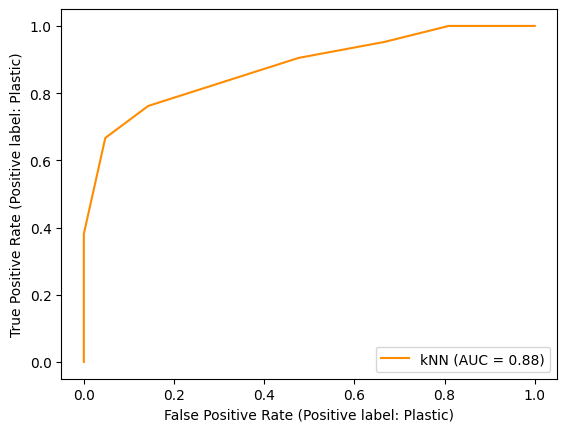

In [ ]:
from sklearn.metrics import RocCurveDisplay
knn_roc = RocCurveDisplay.from_estimator(knn_random_search, X_test, ylab_test, name="kNN", color="darkorange")
plt.show()

## 11) Logistic model

Having proposed and tuned a k-NN model, we try to classify our samples using a logistic model.

Before feeding this model our 2,048 features, we will try a simple logistic model with two features that were identified as highly associated with bottle material during our exploratory analysis. These are features 1,828 and 1,075.

### Decision surface for model with two features

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logistic_estimator = LogisticRegression(penalty=None)

In [ ]:
feat_1828_index = np.where(c2_trainval.drop(['c2_label'], axis=1).columns=="feat_1828")[0][0]
feat_1075_index = np.where(c2_trainval.drop(['c2_label'], axis=1).columns=="feat_1075")[0][0]
X_trainval_two_features = X_trainval[:,[feat_1828_index,feat_1075_index]]

In [ ]:
logistic_estimator.fit(X_trainval_two_features,ylab_trainval)

LogisticRegression(penalty=None)

As a quick test of its performance, we check the accuracy on the combined training/validation sample and see that 75% of samples are correctly classified.

In [ ]:
logistic_estimator.score(X_trainval_two_features,ylab_trainval)

0.7469879518072289

Next, we will plot the decision boundary for this model according to the values in both of those features. This is relatively straightforward to visualize because we have a binary classification problem and only two variables.

In [ ]:
logistic_estimator.classes_

array(['Glass', 'Plastic'], dtype=object)

In [ ]:
#Create a range of values for the two variables (PC1 and PC2)
var1 = np.random.uniform(-1, 10, 500)
var2 = np.random.uniform(-1, 10, 500)
contour_data = np.stack([var1,var2],axis=1)

#Predict the probability of class=Plastic
z = logistic_estimator.predict_proba(contour_data)[:,1]

#Turn into a grid to be used in a contour plot
xi = np.linspace(-1, 10, 500)
yi = np.linspace(-1, 10, 500)
from scipy.interpolate import griddata
zi = griddata((var1, var2), z, (xi[None, :], yi[:, None]), method='linear')

We can see that the model splits the feature space into two areas (glass and plastic) in a linear way. If we had added a third term to our logistic regression (e.g. an interaction term between the two features) we could have achieved a non-linear boundary.

Some of the samples near the boundary are misclassified, but otherwise this simple model performs well.

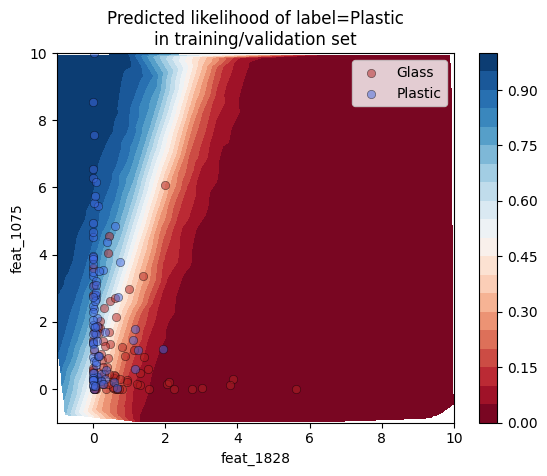

In [ ]:
#Indices for both classes in training/validation set
idx_glass = ylab_trainval=="Glass"
idx_plastic = ylab_trainval=="Plastic"

#Create plot
fig, ax = plt.subplots(nrows=1)

#Add contour plot
ax.contour(xi, yi, zi, levels=14, linewidths=0, colors='k')
cntr1 = ax.contourf(xi, yi, zi, levels=20, cmap="RdBu")

#Add scatter
ax.scatter(X_trainval_two_features[idx_glass,0], X_trainval_two_features[idx_glass,1],
           label="Glass", c="firebrick",alpha=0.5,edgecolor='black',linewidth=0.5)
ax.scatter(X_trainval_two_features[idx_plastic,0], X_trainval_two_features[idx_plastic,1],
           label="Plastic", c="royalblue", alpha=0.5,edgecolor='black',linewidth=0.5)

#Chart settings
fig.colorbar(cntr1, ax=ax)
ax.set(xlim=(-1, 10), ylim=(-1, 10))
ax.set_title("Predicted likelihood of label=Plastic\nin training/validation set")
ax.set_xlabel('feat_1828')
ax.set_ylabel('feat_1075')
ax.legend()

plt.show()

### Model set-up with high-level features

Now, we try a logistic model with all of the features and regularization.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg_estimator = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(penalty="l2"))
    ]
)

In [ ]:
logreg_estimator.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('logreg', LogisticRegression())],
 'verbose': False,
 'scaler': StandardScaler(),
 'logreg': LogisticRegression(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'logreg__C': 1.0,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__l1_ratio': None,
 'logreg__max_iter': 100,
 'logreg__multi_class': 'auto',
 'logreg__n_jobs': None,
 'logreg__penalty': 'l2',
 'logreg__random_state': None,
 'logreg__solver': 'lbfgs',
 'logreg__tol': 0.0001,
 'logreg__verbose': 0,
 'logreg__warm_start': False}

### Grid search with cross-validation to find optimal hyper-parameters

We perform grid search with cross-validation to find the optimal value of C.

In [ ]:
C_vals= np.logspace(-4, 6, num=30)
C_vals

array([1.00000000e-04, 2.21221629e-04, 4.89390092e-04, 1.08263673e-03,
       2.39502662e-03, 5.29831691e-03, 1.17210230e-02, 2.59294380e-02,
       5.73615251e-02, 1.26896100e-01, 2.80721620e-01, 6.21016942e-01,
       1.37382380e+00, 3.03919538e+00, 6.72335754e+00, 1.48735211e+01,
       3.29034456e+01, 7.27895384e+01, 1.61026203e+02, 3.56224789e+02,
       7.88046282e+02, 1.74332882e+03, 3.85662042e+03, 8.53167852e+03,
       1.88739182e+04, 4.17531894e+04, 9.23670857e+04, 2.04335972e+05,
       4.52035366e+05, 1.00000000e+06])

In [ ]:
grid = {
    "logreg__C" : C_vals
}

In [ ]:
logistic_gscv = GridSearchCV(logreg_estimator,
                             grid,
                             cv=5,
                             refit=True,
                             return_train_score=True,
                             verbose=True,
                             n_jobs=-1)

In [ ]:
logistic_gscv.fit(X_trainval, ylab_trainval)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logreg__C': array([1.00000000e-04, 2.21221629e-04, 4.89390092e-04, 1.08263673e-03,
       2.39502662e-03, 5.29831691e-03, 1.17210230e-02, 2.59294380e-02,
       5.73615251e-02, 1.26896100e-01, 2.80721620e-01, 6.21016942e-01,
       1.37382380e+00, 3.03919538e+00, 6.72335754e+00, 1.48735211e+01,
       3.29034456e+01, 7.27895384e+01, 1.61026203e+02, 3.56224789e+02,
       7.88046282e+02, 1.74332882e+03, 3.85662042e+03, 8.53167852e+03,
       1.88739182e+04, 4.17531894e+04, 9.23670857e+04, 2.04335972e+05,
       4.52035366e+05, 1.00000000e+06])},
             return_train_score=True, verbose=True)

In [ ]:
logistic_gscv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_logreg__C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

We can see from our grid search with cross validation that the value of C that maximises the validation accuracy is approximately 0.005.

From our validation curve, we can see that with high values of C (meaning less regularization) the model tends to overfit with an accuracy of 100% on the training set but under 80% on the validation set.

In [ ]:
logreg_results = pd.DataFrame(
    {
        "C": logistic_gscv.cv_results_["param_logreg__C"],
        "mean_tr": logistic_gscv.cv_results_["mean_train_score"],
        "std_tr": logistic_gscv.cv_results_["std_train_score"],
        "mean_val": logistic_gscv.cv_results_["mean_test_score"],
        "std_val": logistic_gscv.cv_results_["std_test_score"]
    }
)

logreg_results.sort_values(by="mean_val", ascending=False)[:10]

C   mean_tr    std_tr  mean_val   std_val
5   0.005298  1.000000  0.000000  0.790018  0.079681
3   0.001083  0.998496  0.003008  0.789840  0.071061
4   0.002395  1.000000  0.000000  0.784135  0.090384
2   0.000489  0.983447  0.012022  0.783779  0.066976
7   0.025929  1.000000  0.000000  0.777718  0.067698
8   0.057362  1.000000  0.000000  0.777718  0.067698
6   0.011721  1.000000  0.000000  0.771836  0.076893
1   0.000221  0.959342  0.013933  0.771658  0.065111
9   0.126896  1.000000  0.000000  0.765597  0.055568
10  0.280722  1.000000  0.000000  0.759715  0.065382

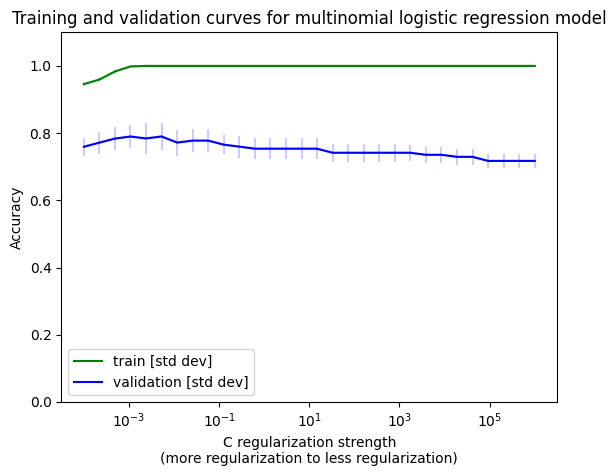

In [ ]:
# Plot mean training scores
plt.semilogx(logreg_results["C"],logreg_results["mean_tr"],label="train [std dev]", color="green")
plt.errorbar(logreg_results["C"],logreg_results["mean_tr"], yerr=logreg_results["std_tr"]*0.5, color="green", alpha=0.2)

# Plot mean validation scores
plt.semilogx(logreg_results["C"],logreg_results["mean_val"],label="validation [std dev]", color="blue")
plt.errorbar(logreg_results["C"],logreg_results["mean_val"], yerr=logreg_results["std_val"]*0.5, color="blue", alpha=0.2)

#Titles and labels
plt.title("Training and validation curves for logistic regression model")
plt.ylabel("Accuracy")
plt.xlabel("C regularization strength\n(more regularization to less regularization)")
plt.ylim(0,1.1)
plt.legend()
plt.show()

### Analyse the model coefficients

Finally, we can analyze the coefficients from the logistic regressions. There are 2,048 coefficients.

The exponential of each coefficient is the odds ratio associated with that coefficient. For each model associated with a class, if the odds ratio is 1.05 and the feature increases by 1 unit, it means that the odds ([P=1]/[P=0]) will increase by 5%.

Similarly, if the odds ratio is 0.95 and the feature increases by 1 unit, it means that the odds ([P=1]/[P=0]) will decrease by 5%. Therefore, odds ratios that are far away from 1 suggest that this feature can discriminate well between that class and all others.

The histogram below shows that most odds ratios have values close to 1, suggesting that _individual_ features alone may not discriminate well between classes.

The odds ratios associated with our two selected features from the first logistic model (1,075 and 1,828) appear in this ranking as well, showing that they are also important factors even when accounting for the impact of all other features.

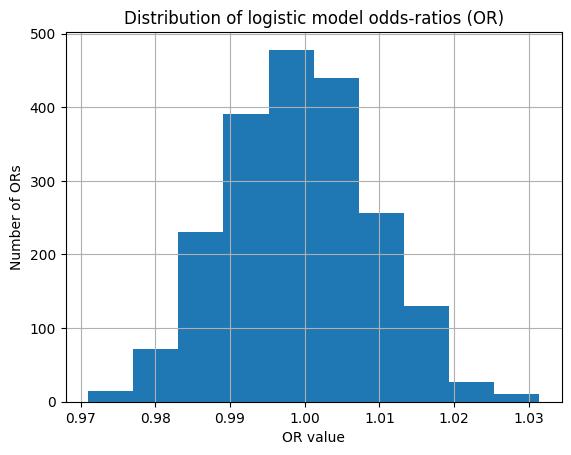

In [ ]:
pd.Series(np.exp(logistic_gscv.best_estimator_.named_steps["logreg"].coef_.ravel())).hist()
plt.title("Distribution of logistic model odds-ratios (OR)")
plt.xlabel("OR value")
plt.ylabel("Number of ORs")
plt.show()
plt.show()

In [ ]:
logistic_coefficients = pd.DataFrame(np.transpose(np.exp(logistic_gscv.best_estimator_.named_steps["logreg"].coef_)),index=c2_trainval.columns[1:], columns=["OR"])

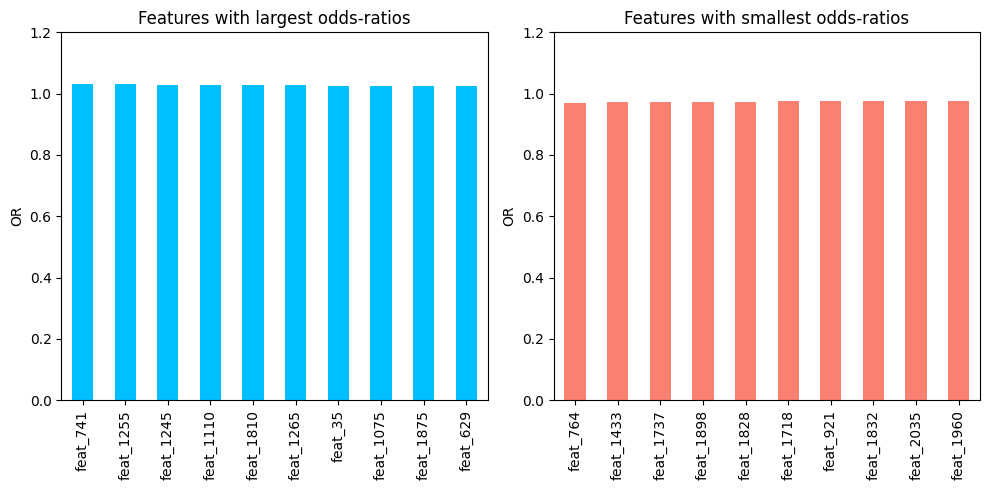

In [ ]:
plt.rcParams["figure.figsize"] = [10,5]
plt.rcParams["figure.autolayout"] = True

plt.subplot(1, 2, 1)
logistic_coefficients.nlargest(10,"OR")["OR"].plot(kind="bar",color="deepskyblue")
plt.ylim([0, 1.2])
plt.title("Features with largest odds-ratios")
plt.ylabel("OR")

plt.subplot(1, 2, 2)
logistic_coefficients.nsmallest(10,"OR")["OR"].plot(kind="bar",color="salmon")
plt.ylim([0, 1.2])
plt.title("Features with smallest odds-ratios")
plt.ylabel("OR")

plt.show()

plt.rcParams.update(plt.rcParamsDefault)

### Assess performance on the test set

Now, we can assess the performance on the test set.

In [ ]:
test_set_predictions = logistic_gscv.predict(X_test)

The overall accuracy is 86%, and both precision and recall are higher than 80% for both types of bottles. In fact, only 6 samples out of 42 have been misclassified.

In [ ]:
get_report(ylab_test, test_set_predictions)

              precision    recall  f1-score   support

       Glass       0.89      0.81      0.85        21
     Plastic       0.83      0.90      0.86        21

    accuracy                           0.86        42
   macro avg       0.86      0.86      0.86        42
weighted avg       0.86      0.86      0.86        42



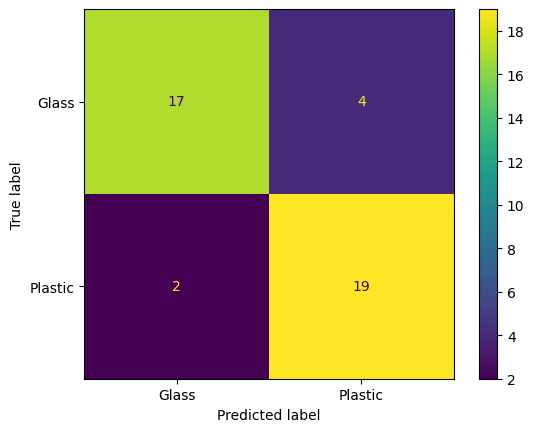

In [ ]:
get_confusion_matrix(ylab_test, test_set_predictions)

This model's ROC curve also confirms that this simple logistic model can lead to predictions with, overall, a low false positive and a high true positive rate.

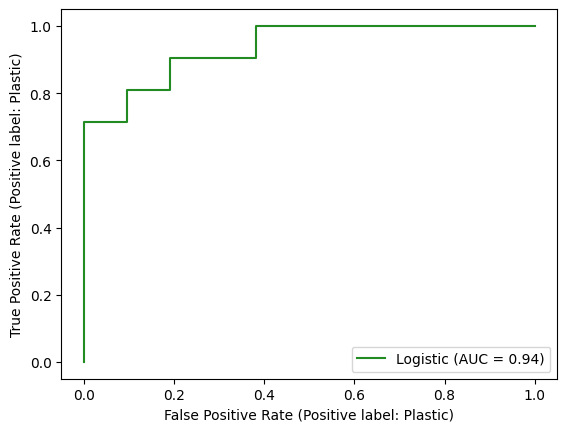

In [ ]:
from sklearn.metrics import RocCurveDisplay
log_roc = RocCurveDisplay.from_estimator(logistic_gscv, X_test, ylab_test, name = "Logistic", color="forestgreen")
plt.show()

## 12) Model comparison

Finally we can compare the performance of our two models and our baseline.

In terms of accuracy, both models perform better than the baseline (50%), which was equivalent to a coin toss.

Looking at the accuracy and the ROC curves, we can see that the logistic (86% accurate) model out-performs the k-NN model (81% accurate) on the test set.

In [ ]:
final_comparison = {
    'KNN' : [knn_random_search.score(X_test, ylab_test)],
    'Logistic regression' : [logistic_gscv.score(X_test, ylab_test)],
    'Baseline (most frequent)': [dummy_clf.score(X_test, ylab_test)]}

final_comparison = pd.DataFrame(final_comparison, index=["accuracy"]).transpose()
final_comparison.sort_values(by="accuracy",inplace=True)

In [ ]:
final_comparison

accuracy
Baseline (most frequent)  0.500000
KNN                       0.809524
Logistic regression       0.857143

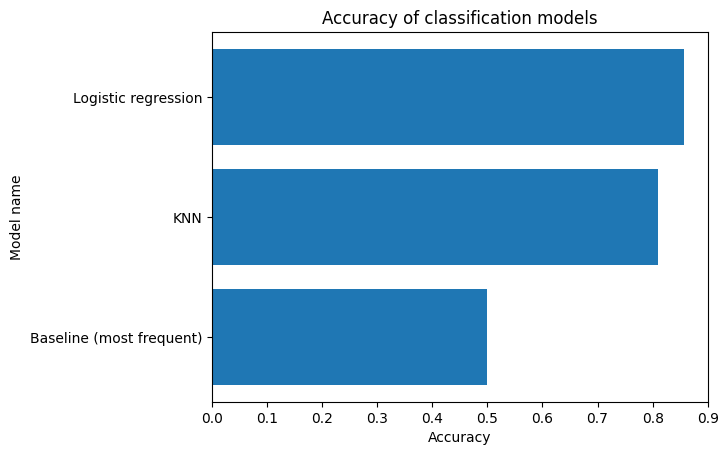

In [ ]:
plt.barh(width=final_comparison.accuracy,y=final_comparison.index)
plt.title("Accuracy of classification models")
plt.ylabel("Model name")
plt.xlabel("Accuracy")
plt.show()

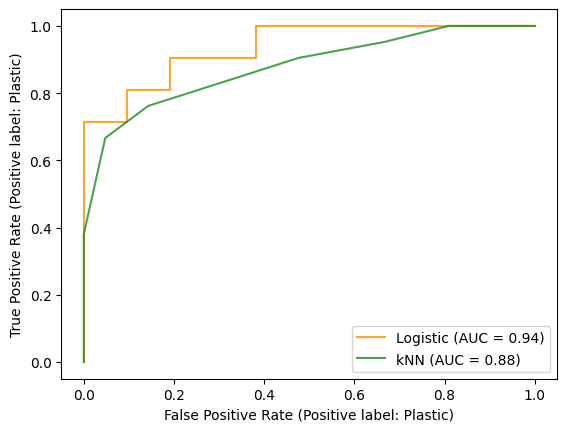

In [ ]:
ax = plt.gca()
log_roc.plot(ax=ax, alpha=0.8, color="darkorange")
knn_roc.plot(ax=ax, alpha=0.8, color="forestgreen")
plt.show()